# Disease_Similarity_Benchmark

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-02-27 13:29:01,516 - INFO - Nº of processed ids: 7191
2024-02-27 13:29:02,358 - INFO - Nº of processed ids in df_data_info: 7191
2024-02-27 13:29:02,360 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

2024-02-27 13:32:47,170 - INFO - Nº of Human protein coding genes: 20607


In [3]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-02-27 13:32:47,341 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [4]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 2592647.21it/s]


In [5]:
from tqdm.contrib.concurrent import process_map


human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

signatures = process_map(
    get_signatures,
    human_dsaids_processed,
    max_workers=8,
    chunksize=10,
)

/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 7001/7001 [02:56<00:00, 39.57it/s] 


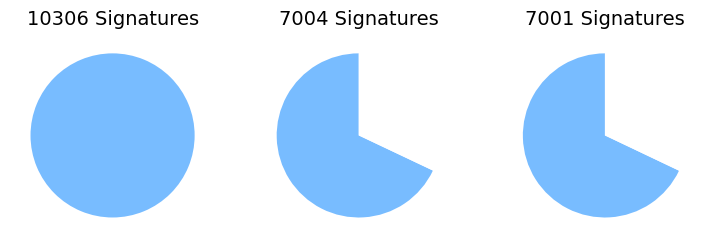

In [6]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "RNA-Seq")
        | (df_data_info["library_strategy"] == "Microarray")
    )
].shape[0]
n_step_2 = df_data_info_processed_filtered.shape[0]

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures", fontsize=14)
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures", fontsize=14)
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures", fontsize=14)
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join("..", "results", "figures", "DiSignAtlas", "pre_process.png"),
    bbox_inches="tight",
    dpi=300,
)

In [7]:
logging.info(
    f"Nº of non-redundant diseases initially: {df_data_info['disease'].nunique()}"
)
logging.info(
    f"Nº of non-redundant diseases after pre-processing: {df_data_info_processed_filtered['disease'].nunique()}"
)

2024-02-27 13:35:46,488 - INFO - Nº of non-redundant diseases initially: 1836
2024-02-27 13:35:46,488 - INFO - Nº of non-redundant diseases after pre-processing: 1428


In [8]:
interesting_dsaids = []
n_std = list()
vector_len = list()
for i, s in enumerate(tqdm(signatures)):
    if np.any(np.array(s[5]) > 500) or np.any(np.array(s[5]) < -500):
        interesting_dsaids.append((i, s[0], max(s[5]), min(s[5])))

    # compute std
    std = np.std(signatures[i][5])
    mean = np.mean(signatures[i][5])

    n = len(
        [
            value
            for value in signatures[i][5]
            if (value > mean + 6 * std) or (value < mean - 6 * std)
        ]
    )

    vector_len.append(len(signatures[i][5]))
    n_std.append(n)

logging.info(f"Nº of dsaids w/ extreme log2fc: {len(interesting_dsaids)}")
logging.info(f"Signatures: {interesting_dsaids}")

100%|██████████| 7001/7001 [00:34<00:00, 202.71it/s]
2024-02-27 13:36:21,033 - INFO - Nº of dsaids w/ extreme log2fc: 3
2024-02-27 13:36:21,033 - INFO - Signatures: [(3379, 'DSA04659', 283010.779335352, -99319.619817649), (3380, 'DSA04660', 367171.584055279, -408566.783065797), (6416, 'DSA09547', 61042.6740428988, -355887.1218498)]


## Define Sparsity & Matrix Dimensions

In [99]:
""" Define Sparsity & Matrix Dimensions

Structure:
    1. Import, Variables and Functions
    2. Get the most common gene ids
    3. Get the dsaids with the most common gene ids
    4. Create the data matrix
"""

# Imports, Variables and Functions
# imports

from collections import Counter

# variabels
sparsity = "HS"
sparsity_perc_sign_thr = {"LS": 0.8878, "HS": 0.25}
sparsity_perc_genes_thr = {"LS": 0.95, "HS": 0.5}
assert sparsity in ["LS", "HS"], "Err Sparsity not recognized"


# functions


def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


# 2. Get the most common gene ids
# Map all human protein-coding genes to the signatures
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

# Get the sorted counts of protein-coding genes
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

# Get depending on the sparsity the most common gene ids of interest
most_common_gene_ids = [
    k
    for k, v in counts_all_gene_ids_protein_coding.items()
    if v >= int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))
]

logging.info(
    f"{sparsity} Most common gene ids: {len(most_common_gene_ids)} for {sparsity} >= {int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))} / {len(signatures)}"
)

# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)


# 3. Get the dsaids with the most common gene ids
# dsaids w/ gene ids
# loop through signatures and get dsaids with an intersection against
# the most common gene ids above or equal to a threshold
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    >= int(len(most_common_gene_ids) * sparsity_perc_genes_thr.get(sparsity))
]

logging.info(
    f"Nº of dsaids w/ common gene ids {sparsity}: {len(dsaids_common_gene_ids)}"
)

# 4. Create the data matrix
# create data matrix
data_matrix = np.zeros((len(dsaids_common_gene_ids), len(most_common_gene_ids)))

logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")

2024-02-27 17:42:53,230 - INFO - HS Most common gene ids: 18561 for HS >= 1750 / 7001
2024-02-27 17:42:59,635 - INFO - Nº of dsaids w/ common gene ids HS: 6513
2024-02-27 17:42:59,705 - INFO - Data matrix HS shape: (6513, 18561)


In [83]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  all_gene_ids: 1008.0 MiB
                   data_matrix: 922.3 MiB
                  _data_matrix: 732.0 MiB
                   matrix_rest: 716.8 MiB
    matrix_pearson_correlation: 203.8 MiB
     matrix_euclidean_distance: 203.8 MiB
        matrix_cosine_distance: 203.8 MiB
    _matrix_euclidean_distance: 101.9 MiB
       _matrix_cosine_distance: 101.9 MiB
                      nan_mask: 91.5 MiB


### Compute Matrix

In [100]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

# variables
metric_evaluated = "Ranking.Log2FC"

d_default_value = {
    "AdjPValue": 1.0,
    "Log2FC": 0.0,
    "iLINCS.100": 0.0,
    "iLINCS.200": 0.0,
    "Ranking.AdjPValue": 0.0,
    "Ranking.Log2FC": 0.0,
}

variance_thr = 0.0
de_genes_thr = 30

assert metric_evaluated in [
    "AdjPValue",
    "Log2FC",
    "iLINCS.100",
    "iLINCS.200",
    "Ranking.AdjPValue",
    "Ranking.Log2FC",
], "Err metric not found"


# functions


def filter_information(reference, labels, values):
    """Filter information by reference
    Args:
        - reference (list): list of reference ids
        - labels (list): list of labe{sparsity}
        - values (list): list of values
    Returns:
        - labels (np.array): np.array of labels
        - values (np.array): np.array of values
    """
    reference = np.array(reference)
    labels = np.array(labels)
    values = np.array(values)
    mask = np.isin(labels, reference)
    return labels[mask], values[mask]


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


def compute_signed_significance(p_values, log2fcs):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    p_values = np.array(p_values)
    log2fcs = np.array(log2fcs)

    assert len(p_values) == len(log2fcs), "Err p_values and log2fcs not same length"
    signed_significance = list()
    for p_value, logfc in zip(p_values, log2fcs):
        # P Value should neve be 0
        if p_value == 0:
            p_value = min(p_values[p_values != 0])
        # chek if p_value is nan
        if not np.isnan(p_value):
            sign = np.sign(logfc)
            ss = sign * (-np.log10(p_value))
            signed_significance.append(ss)
        if np.isnan(p_value):
            raise ValueError("Log2FC is nan")
    return np.array(signed_significance)


def compute_extreme_signed_significance(signed_significance, genes, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance (np.array): list of signed significance

    - genes (np.array): list of gene ids

    - k: int()
        Top/Bottom k genes.

    Returns:
    - genes: list of gene ids
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # check if there are nans in the signed significance
    signed_significance_no_nan = signed_significance[~np.isnan(signed_significance)]
    signed_significance_nan = signed_significance[np.isnan(signed_significance)]

    genes_no_nan = genes[~np.isnan(signed_significance)]
    genes_nan = genes[np.isnan(signed_significance)]

    # Sort the signed_significance_no_nan in ascending order and get sorted indices
    sorted_indices = np.argsort(signed_significance_no_nan)

    # Apply sorting to both signed_significance_no_nan and genes_no_nan
    sorted_signed_significance_no_nan = signed_significance_no_nan[sorted_indices]
    sorted_genes_no_nan = genes_no_nan[sorted_indices]

    # Initialize a mask for all values as False (indicating all will be set to 0)
    mask = np.zeros(sorted_signed_significance_no_nan.shape, dtype=bool)

    # if there are 0s in the top or bottom 100 then they will be still 0's
    # after the mask

    # Set True for the top 100 (smallest) and bottom 100 (largest) values in ascending order
    mask[:k] = True  # Smallest values
    mask[-k:] = True  # Largest values before NaNs

    # Apply the mask, setting values not in the top or bottom 100 to 0
    sorted_signed_significance_no_nan[~mask] = 0

    # Concatenate with NaN parts
    final_signed_significance = np.concatenate(
        [sorted_signed_significance_no_nan, signed_significance_nan]
    )
    final_genes = np.concatenate([sorted_genes_no_nan, genes_nan])
    return final_genes, final_signed_significance


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
dsaids_matrix = list()
rows_filled = 0
if metric_evaluated.startswith("iLINCS"):
    n_ess = list()

for i, dsaid_specific in enumerate(tqdm(dsaids_common_gene_ids)):
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )
    elif metric_evaluated.startswith("iLINCS"):
        """Wer are computing the extreme signed significance for
        those genes of interest. Not for all genes. This is a decision
        which is arbitrary. Justification is that we are interested in
        the scope of genes of interest.
        """
        # filter adj_p_values
        filtered_gene_ids, filtered_adj_p_values = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=adj_p_values
        )

        # filter log2fc
        filtered_gene_ids, filtered_log2fc = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=log2fc
        )

        # compute signed significance
        signed_significance = compute_signed_significance(
            filtered_adj_p_values, filtered_log2fc
        )

        # compute extreme signed significance
        gene_ids_ess, ess = compute_extreme_signed_significance(
            signed_significance=signed_significance,
            genes=filtered_gene_ids,
            k=int(metric_evaluated.split(".")[1]),
        )

        # sort values
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids_ess,
            values=ess,
        )

    if metric_evaluated == "Ranking.AdjPValue":

        # compute ranking
        ranking = compute_ranking_adj_pvalue(adj_p_values, n=200, threshold=0.05)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Ranking.Log2FC":

        # compute ranking
        ranking = compute_ranking_log2fc(log2fc, n=100, threshold=0.5)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    # check variance for specific genes
    check = False
    if np.var(np.array(sorted_values)[~np.isnan(sorted_values)]) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)
        check = True
        continue

    # check nº of extreme signed significance genes
    if metric_evaluated.startswith("iLINCS"):
        ess_no_nan = ess[~np.isnan(ess)]
        if np.array(ess_no_nan, dtype="bool").sum() <= de_genes_thr:
            continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix = data_matrix[:rows_filled, :]
logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")


# report how many dsaids have zero variance
logging.info(
    f"{sparsity} Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}"
)
logging.info(
    f"{sparsity} Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix.shape[1]):
    if np.var(data_matrix[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix.shape[0]):
    if np.var(data_matrix[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"

# check de genes in iLINCS processing
for row in range(data_matrix.shape[0]):
    if data_matrix[row, :].astype(bool).sum() <= de_genes_thr:
        raise ValueError(f"{sparsity} Err nº of DE genes <= {de_genes_thr}")

# mask where there are nans
nan_mask = np.isnan(data_matrix)

# assign nans default value
data_matrix[nan_mask] = d_default_value.get(metric_evaluated)

100%|██████████| 6513/6513 [00:48<00:00, 133.96it/s]
2024-02-27 17:43:48,345 - INFO - Data matrix HS shape: (6465, 18561)
2024-02-27 17:43:48,345 - INFO - HS Zero variance dsaids all genes: 22
2024-02-27 17:43:48,345 - INFO - HS Zero variance dsaids specific genes: 26


In [101]:
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

logging.info(f"Nº signatures {df_matrix.shape[0]}")
logging.info(f"Nº unique diseases {df_matrix['disease'].nunique()}")

2024-02-27 17:43:49,830 - INFO - Nº signatures 6465
2024-02-27 17:43:49,831 - INFO - Nº unique diseases 1379


In [102]:
metric_evaluated = "iLINCS" if metric_evaluated == "iLINCS.100" else metric_evaluated

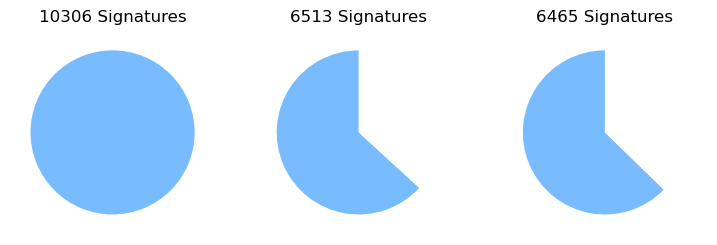

In [103]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = len(dsaids_common_gene_ids)
n_step_2 = len(dsaids_matrix)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures")
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures")
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures")
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join(
        "..", "results", "figures", "DiSignAtlas", f"data_process.{sparsity}.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

In [104]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_common_gene_ids])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases: {len(diseases_to_check)}")

# get disease to dsaids of interest
dsaid_2_disease_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    if disease in diseases_to_check:
        # check if dsaids are in matrix ids
        if dsaid in dsaids_matrix:
            if disease not in dsaid_2_disease_filtered.keys():
                dsaid_2_disease_filtered[disease] = list()
            dsaid_2_disease_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in dsaid_2_disease_filtered.items() if len(v) >= 5]

logging.info(f"Size disease to dsaids: {len(most_common_diseases)}")

2024-02-27 17:43:49,980 - INFO - Nº of most common diseases: 257
2024-02-27 17:43:50,125 - INFO - Size disease to dsaids: 257


<Figure size 400x400 with 0 Axes>

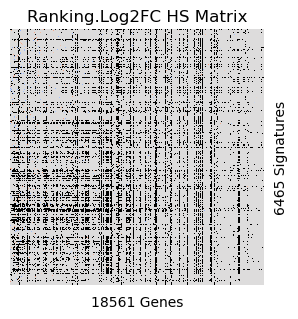

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))


# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


cmap.set_bad(color="black")

if metric_evaluated == "AdjPValue":
    min_val = 0
    max_val = 1
    cluster = True
elif metric_evaluated == "Log2FC":
    min_val = -3
    max_val = 3
    cluster = True
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
    cluster = False
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
    cluster = False

elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200
    cluster = False


# subset data matrix

rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)

# Plot the clustermap without dendrograms and color bar
cg = sns.clustermap(
    data_matrix[rows][:, cols],
    cmap=cmap,
    mask=nan_mask[rows][:, cols],
    row_cluster=True,
    col_cluster=True,
    # dendrogram_ratio=(0.1, 0.1),  # Very small dendrogram size
    figsize=(4, 4),  # Control the size of the clustermap here
    cbar_pos=None,
    vmin=min_val,
    vmax=max_val,
)  # No color bar

# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines

plt.title(f"{metric_evaluated} {sparsity} Matrix")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cluster_map.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

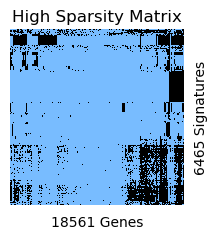

In [106]:
from matplotlib.colors import ListedColormap

# Define a custom color map: 1s in blue, 0s in black
cmap = sns.color_palette("light:b", as_cmap=True)
cmap.set_bad(color="black")


_data_matrix = data_matrix.copy()
_data_matrix = np.ones_like(_data_matrix)
_data_matrix[nan_mask] = 0

# Define a custom color map: 1s in blue, 0s in black, NaNs in gray
cmap = ListedColormap(["black", "#78bcff"])
cmap.set_bad("gray", 1.0)  # Handle NaN values, setting them to gray

# Randomly select rows and columns
rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)


# Plot the cluster map without applying nan_mask as mask parameter since we've handled NaNs
cg = sns.clustermap(
    _data_matrix[rows][:, cols],
    cmap=cmap,
    figsize=(3, 3),
    cbar_pos=None,
    col_cluster=True,
    row_cluster=True,
    vmin=0,  # Minimum value for color mapping
    vmax=1,  # Maximum value for color mapping
)


# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines
plt.title("%s Matrix" % {"LS": "Low Sparsity", "HS": "High Sparsity"}[sparsity])
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cluster_map.nans.{sparsity}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

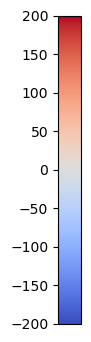

In [107]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Set min and max values based on 'metric_evaluated'
if metric_evaluated == "AdjPValue":
    min_val = 0
    max_val = 1
elif metric_evaluated == "Log2FC":
    min_val = -3
    max_val = 3
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200

# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


# Create a figure for the color bar
fig, ax = plt.subplots(figsize=(0.3, 4))

# Create a scalar mappable for the color bar
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can safely ignore this line as it's just to avoid warnings

# Create the color bar
cbar = plt.colorbar(sm, cax=ax)

# Set the label of the color bar based on the metric evaluated
# cbar.set_label(metric_evaluated)

# Move color bar tick labels and lines to the left
cbar.ax.yaxis.set_ticks_position("left")  # This moves tick lines to the left
cbar.ax.yaxis.set_label_position(
    "left"
)  # This ensures the label is aligned with the ticks
cbar.ax.yaxis.set_tick_params(
    labelleft=True, labelright=False
)  # Adjusts labels to the left


# Save the color bar as a separate figure
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cbar_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

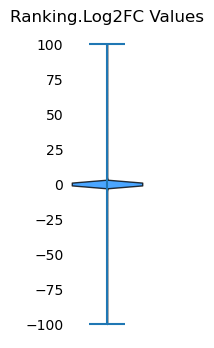

In [108]:
# plot value distribution

values = [np.min(data_matrix)]
values.append(np.max(data_matrix))
values.extend(np.random.choice(data_matrix.flatten(), 5000, replace=False))


plt.figure(figsize=(1, 4))
violin_parts = plt.violinplot(
    values,
    showmeans=False,
    showmedians=False,
    showextrema=True,  # Hides the min, max, median, and mean indicators
)


# Customize the appearance of the violin plot
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("black")
violin_parts["bodies"][0].set_alpha(0.8)

# remove y ticks
plt.xticks([])
plt.tick_params(
    axis="y", which="both", length=0
)  # Set the tick length to 0 for the y-axis

# Remove the spines of the top, bottom, and left
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Move y-axis ticks to the right
# plt.gca().yaxis.tick_right()
title = f"{metric_evaluated} Values"
if metric_evaluated == "Log2FC":
    title = f"{metric_evaluated} Values"

if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"value_distribution.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

### Compute Correlations

In [109]:
# imports
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random

# variables
k_percent = 0.2
n_bootstrap = 100


#  functions
def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


def check_old_method_correlation(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def check_old_method_cosine(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="cosine")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def check_old_method_euclidean(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="euclidean")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def get_top_k(array, k, percent=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = int(k * len(array))

    # Using numpy.argsort to get indices of the k top highest values
    indices = np.argsort(array)[-k:]

    # Sorting indices if you want them in the order of the corresponding values
    sorted_indices = indices[np.argsort(array[indices])][::-1]

    # Getting the top k values using the sorted indices
    top_k_values_from_indices = array[sorted_indices]
    return top_k_values_from_indices


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

In [110]:
correlation_values_interest_all = list()
correlation_values_rest_all = list()
correlation_values_interest_top_k = list()
correlation_values_rest_top_k = list()

cosine_values_interest_all = list()
cosine_values_rest_all = list()
cosine_values_interest_top_k = list()
cosine_values_rest_top_k = list()

euclidean_values_interest_all = list()
euclidean_values_rest_all = list()
euclidean_values_interest_top_k = list()
euclidean_values_rest_top_k = list()

# get values
quality_check = random.choice(list(range(len(most_common_diseases))))
quality_check = 0
logging.info(f"Quality check: {quality_check} {most_common_diseases[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # interest indexes pairs
    """We have a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    interest_idxs_pairs = list()  # list of lists
    for i in range(len(interest_idxs)):
        _rows_list = list()  # list
        for j in range(len(interest_idxs)):
            if i != j:  # exclude itself from the comparison
                _rows_list.append([interest_idxs[i], interest_idxs[j]])
        interest_idxs_pairs.append(_rows_list)

    interest_idxs_pairs = np.array(interest_idxs_pairs)

    # get pearson correlation

    # iterate through all pairs for a given disease signature
    correlation_values_interest_top_k_per_disease = list()
    correlation_values_interest_per_disease = list()

    cosine_values_interest_top_k_per_disease = list()
    cosine_values_interest_per_disease = list()

    euclidean_values_interest_top_k_per_disease = list()
    euclidean_values_interest_per_disease = list()
    for row_interest in interest_idxs_pairs:

        # get correlation values for all elements of a row/signature
        correlation_values_interest = matrix_pearson_correlation[
            row_interest[:, 0], row_interest[:, 1]
        ]
        correlation_values_interest_per_disease.extend(correlation_values_interest)

        # get top k values
        top_k_values = get_top_k(correlation_values_interest, k=1)
        correlation_values_interest_top_k_per_disease.extend(top_k_values)

        # get cosine values for all elements of a row/signature
        cosine_values_interest = matrix_cosine_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]
        cosine_values_interest_per_disease.extend(cosine_values_interest)

        # get top k values
        top_k_cosine = get_top_k(cosine_values_interest, k=1)
        cosine_values_interest_top_k_per_disease.extend(top_k_cosine)

        # get euclidean values for all elements of a row/signature
        euclidean_values_interest = matrix_euclidean_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]
        euclidean_values_interest_per_disease.extend(euclidean_values_interest)

        # get top k values
        top_k_euclidean = get_top_k(euclidean_values_interest, k=1)
        euclidean_values_interest_top_k_per_disease.extend(top_k_euclidean)

    # list of diseases with a list of similarities per disease
    correlation_values_interest_top_k.append(
        correlation_values_interest_top_k_per_disease
    )
    correlation_values_interest_all.append(correlation_values_interest_per_disease)

    cosine_values_interest_all.append(cosine_values_interest_per_disease)
    cosine_values_interest_top_k.append(cosine_values_interest_top_k_per_disease)

    euclidean_values_interest_all.append(euclidean_values_interest_per_disease)
    euclidean_values_interest_top_k.append(euclidean_values_interest_top_k_per_disease)

    # quality check
    if count == quality_check:

        # check pearson correlation
        old_value_correlation = check_old_method_correlation(
            dsaids_interest, data_matrix
        )
        assert "%.7f" % old_value_correlation == "%.7f" % np.mean(
            correlation_values_interest_per_disease
        ), "Err something wrong computing correlation"

        # check cosine distance
        old_value_cosine = check_old_method_cosine(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_cosine == "%.7f" % np.mean(
            cosine_values_interest_per_disease
        ), "Err something wrong computing cosine"
        # check euclidean distance
        old_value_euclidean = check_old_method_euclidean(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_euclidean == "%.7f" % np.mean(
            euclidean_values_interest_per_disease
        ), "Err something wrong computing euclidean"

    # get rest indexes
    rest_indxs = list(set(all_indexes) - set(interest_idxs))

    # bootstrap method
    """Here we will create a list of list of lists. First list will be the nº 
    of resampling - the second will be a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs  """

    rest_idxs_pairs = list()  # list of list of lists
    for _ in range(n_bootstrap):
        # Sample with replacement
        rest_indxs_sample = np.random.choice(
            rest_indxs, size=int(len(interest_idxs)), replace=True
        )
        _rows_list_sublist = list()  # list of list
        for idx_interest in interest_idxs:
            _rows_list = list()  # list
            for idx_other in rest_indxs_sample:
                _rows_list.append([idx_interest, idx_other])
            _rows_list_sublist.append(_rows_list)
        rest_idxs_pairs.append(_rows_list_sublist)

    rest_idxs_pairs = np.array(rest_idxs_pairs)
    # get pearson correlation against random diseases

    # iterate through all the sample indexes
    correlation_values_rest_disease = list()
    correlation_values_top_k_disease = list()

    cosine_values_rest_disease = list()
    cosine_values_top_k_disease = list()

    euclidean_values_rest_disease = list()
    euclidean_values_top_k_disease = list()
    for sample_idxs in rest_idxs_pairs:
        correlation_values_sample = list()  # contains all values for a sample
        correlation_values_top_k_sample = list()  # contains top k values for a sample

        cosine_values_sample = list()
        cosine_values_top_k_sample = list()

        euclidean_values_sample = list()
        euclidean_values_top_k_sample = list()

        # iterate through list of all pairs for a given disease signature
        for row_sample_idxs in sample_idxs:

            # get for a given row all pre-computed correlation values
            correlation_values_rest = matrix_pearson_correlation[
                row_sample_idxs[:, 0], row_sample_idxs[:, 1]
            ]
            correlation_values_sample.extend(correlation_values_rest)

            # get top k values
            top_k_values = get_top_k(correlation_values_rest, k=1)
            correlation_values_top_k_sample.extend(top_k_values)

            # get for a given row all pre-computed correlation values
            cosine_values_rest = matrix_cosine_distance[
                row_sample_idxs[:, 0], row_sample_idxs[:, 1]
            ]
            cosine_values_sample.extend(cosine_values_rest)

            # get top k values
            top_k_cosine = get_top_k(cosine_values_rest, k=1)
            cosine_values_top_k_sample.extend(top_k_cosine)

            # get for a given row all pre-computed correlation values
            euclidean_values_rest = matrix_euclidean_distance[
                row_sample_idxs[:, 0], row_sample_idxs[:, 1]
            ]
            euclidean_values_sample.extend(euclidean_values_rest)

            # get top k values
            top_k_euclidean = get_top_k(euclidean_values_rest, k=1)
            euclidean_values_top_k_sample.extend(top_k_euclidean)

        # append to list of lists
        correlation_values_rest_disease.append(correlation_values_sample)
        correlation_values_top_k_disease.append(correlation_values_top_k_sample)

        cosine_values_rest_disease.append(cosine_values_sample)
        cosine_values_top_k_disease.append(cosine_values_top_k_sample)

        euclidean_values_rest_disease.append(euclidean_values_sample)
        euclidean_values_top_k_disease.append(euclidean_values_top_k_sample)

    # list of list of lists
    correlation_values_rest_all.append(correlation_values_rest_disease)
    correlation_values_rest_top_k.append(correlation_values_top_k_disease)

    cosine_values_rest_all.append(cosine_values_rest_disease)
    cosine_values_rest_top_k.append(cosine_values_top_k_disease)

    euclidean_values_rest_all.append(euclidean_values_rest_disease)
    euclidean_values_rest_top_k.append(euclidean_values_top_k_disease)


assert (
    len(most_common_diseases)
    == len(correlation_values_interest_all)
    == len(correlation_values_rest_all)
    == len(correlation_values_interest_top_k)
    == len(correlation_values_rest_top_k)
), "Err something wrong with the length of the lists"

2024-02-27 17:50:26,222 - INFO - Quality check: 0 Myotonic Dystrophy Type 1
100%|██████████| 257/257 [05:09<00:00,  1.20s/it]


In [111]:
# # Compute the AUROC and AUPRC

# import numpy as np
# from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve

# # Assuming correlation_values_interest_all[0] and correlation_values_rest_all[0] are your arrays of scores
# scores_interest = correlation_values_interest_all[
#     100
# ]  # Scores for the 'interest' class
# scores_rest = correlation_values_rest_all[100]  # Scores for the 'rest' class

# # Combine the scores
# scores = np.concatenate([scores_interest, scores_rest])

# # Generate true labels: 1 for 'interest' class, 0 for 'rest' class
# true_labels = np.concatenate(
#     [np.ones(len(scores_interest)), np.zeros(len(scores_rest))]
# )

# # Compute AUROC
# fpr, tpr, thresholds = roc_curve(true_labels, scores)
# auroc = auc(fpr, tpr)

# # Compute AUPRC
# precision, recall, thresholds = precision_recall_curve(true_labels, scores)
# auprc = auc(recall, precision)

# print(f"AUROC: {auroc}, AUPRC: {auprc}")

### Plots

In [112]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

#### Pearson Correlations

2024-02-28 10:48:08,594 - INFO - Nº of values: 257 257


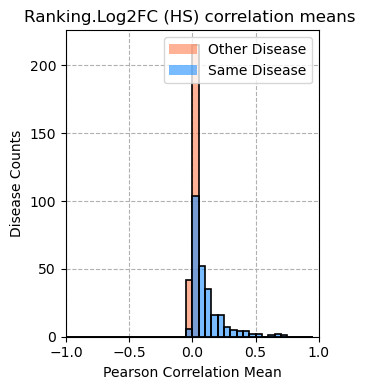

In [122]:
# Plot Pearson Correlation
# Correlation values mean with

value_1 = [np.mean(i) for i in correlation_values_interest_all]
value_2 = list()

for disease_samples in correlation_values_rest_all:
    _value_2 = list()
    for sample in disease_samples:
        _value_2.append(np.mean(sample))
    value_2.append(np.mean(_value_2))
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1, 0.05)]

# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} ({sparsity}) correlation means ")
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pearson_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

2024-02-28 10:48:16,827 - INFO - Nº of values: 257 257


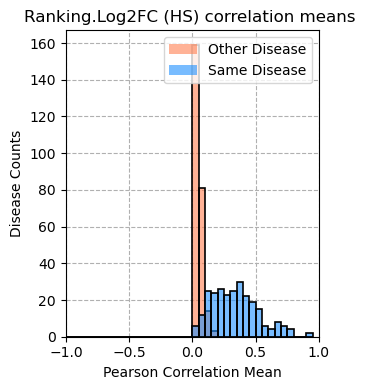

In [123]:
# Plot Pearson Correlation

value_1 = [np.mean(i) for i in correlation_values_interest_top_k]
value_2 = list()
for disease_samples in correlation_values_rest_top_k:
    _value_2 = list()
    for sample in disease_samples:
        _value_2.append(np.mean(sample))
    value_2.append(np.mean(_value_2))
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")


colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1, 0.05)]

# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} ({sparsity}) correlation means ")
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pearson_correlation.top_1.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

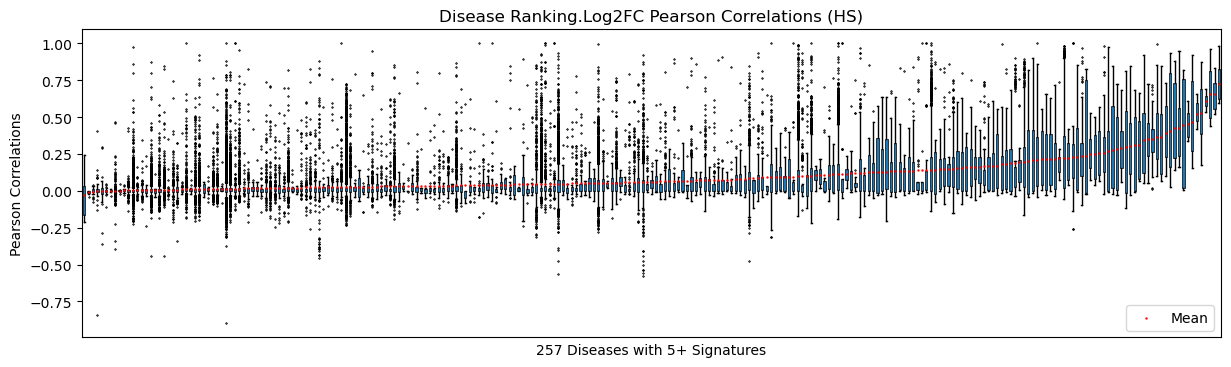

In [115]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = [np.mean(i) for i in data]
sorted_indices = np.argsort(means)
sorted_data = [data[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(14.7, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(f"Disease {metric_evaluated} Pearson Correlations ({sparsity})")
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
# plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

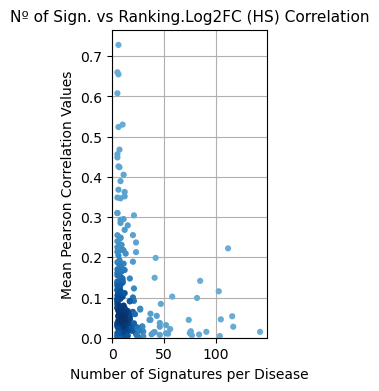

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in correlation_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(dsaid_2_disease_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(2, 4))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Nº of Sign. vs {metric_evaluated} ({sparsity}) Correlation", fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Pearson Correlation Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

(0.0, 1.049999925106078)

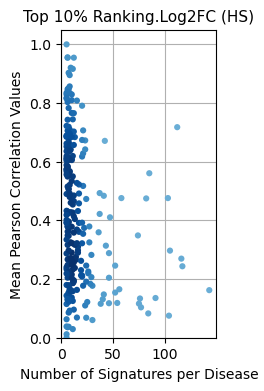

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in correlation_values_interest_top_k]

# number of signatures per disease
n_signatures_per_disease = [
    len(dsaid_2_disease_filtered.get(disease)) for disease in most_common_diseases
]

# Correlation values
values_1 = list()
for i in range(len(correlation_values_interest_all)):
    n = int(len(correlation_values_interest_all[i]) * 0.1)
    values_1.append(np.mean(sorted(correlation_values_interest_all[i])[-n:]))


# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(2, 4))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Top 10% {metric_evaluated} ({sparsity})", fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Pearson Correlation Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
# plt.savefig(
#     os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         f"scatter_plot.diseases_correlation.{sparsity}.adj_p_values.top_10_perc.png",
#     ),
#     dpi=300,
#     bbox_inches="tight",
# )

#### Euclidean Distances

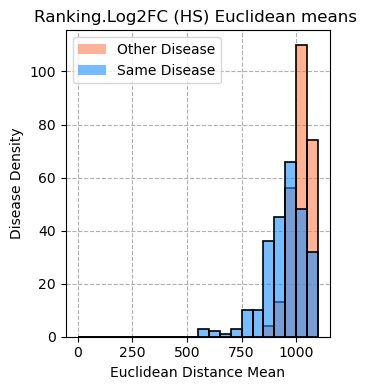

In [118]:
# Plot Euclidean Distances

value_1 = [np.mean(i) for i in euclidean_values_interest_all]
value_2 = list()
for disease_samples in euclidean_values_rest_all:
    _value_2 = list()
    for sample in disease_samples:
        _value_2.append(np.mean(sample))
    value_2.append(np.mean(_value_2))

colors = {0: "#1E90FF", 1: "#FF7F50"}

if metric_evaluated == "AdjPValue":
    fixed_bins = [
        i
        for i in np.arange(
            0,
            max(value_1 + value_2),
            np.std(value_1) / 2,
        )
    ]
    max_val = max(value_1 + value_2)

elif metric_evaluated == "Log2FC":
    fixed_bins = [
        i
        for i in np.arange(
            0,
            max(value_1 + value_2),
            50,
        )
    ]
    max_val = np.mean(value_1) + 0.75 * np.std(value_1)
    max_val = 2600

elif metric_evaluated.startswith("Ranking"):
    fixed_bins = [
        i
        for i in np.arange(
            0,
            max(value_1 + value_2),
            50,
        )
    ]

    max_val = 5 * np.std(value_1) if sparsity == "HS" else 1 * np.std(value_1)


# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} ({sparsity}) Euclidean means ")
plt.legend()
plt.xlabel("Euclidean Distance Mean")
# plt.xlim(0, max_val)
plt.ylabel("Disease Density")
plt.grid(linestyle="--")
plt.tight_layout()

# plt.text(0,0,s=f"max euclidean: {max(euclidean_values_rest_mean)}", fontsize=12)

# plt.xscale("log")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"euclidean.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cosine Distances

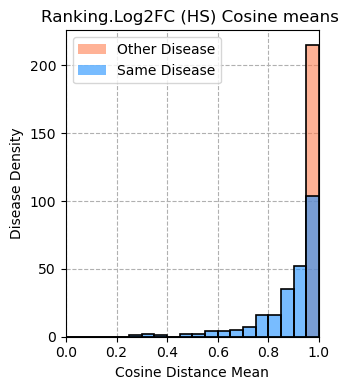

In [119]:
# Plot Cosine Distances

value_1 = [np.mean(i) for i in cosine_values_interest_all]
value_2 = list()
for disease_samples in cosine_values_rest_all:
    _value_2 = list()
    for sample in disease_samples:
        _value_2.append(np.mean(sample))
    value_2.append(np.mean(_value_2))

colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [
    i
    for i in np.arange(
        0,
        1.01,
        0.05,
    )
]


# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)


# Finalizing plot
plt.title(f"{metric_evaluated} ({sparsity}) Cosine means ")
plt.legend()
plt.xlabel("Cosine Distance Mean")
plt.xlim(0, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Density")
plt.grid(linestyle="--")
plt.tight_layout()


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"cosine.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
title = f"Nº of Sign. vs {metric_evaluated} ({sparsity}) Correlation"
title = title if len(title) < 38 else title[:35] + "..."
print(title)
len(title)

#### Cherry-picked diseases: tSNE & Pearson Correlations

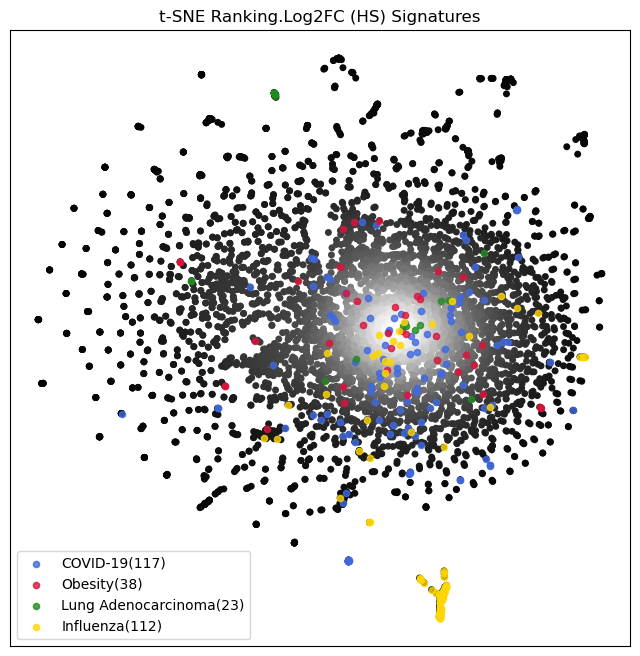

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

single_disease_examples = [
    "COVID-19",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)
embedded_data = tsne.fit_transform(data_matrix)


# Standardize the t-SNE embeddings (important for density calculation)
scaler = StandardScaler()
scaled_embedded_data = scaler.fit_transform(embedded_data)

# Calculate the density of points in the t-SNE space using Gaussian KDE
bandwidth = 0.3  # Bandwidth parameter for KDE
kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
density = kde(scaled_embedded_data.T)

# Create a scatter plot with colors based on local density
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=25,
    edgecolor="none",
)

# specific indexes
d_disease_2_index = dict()
for i, disease in enumerate(single_disease_examples):
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=f"{disease}({len(interest_idxs)})",
        s=20,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE {metric_evaluated} ({sparsity}) Signatures")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


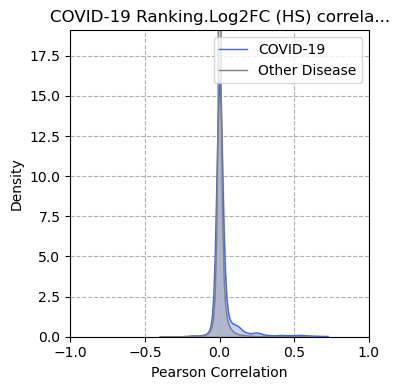

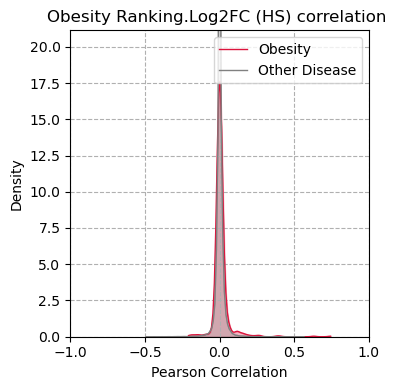

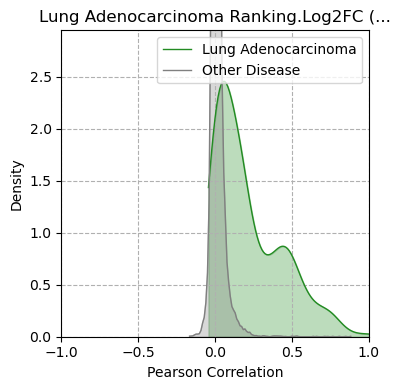

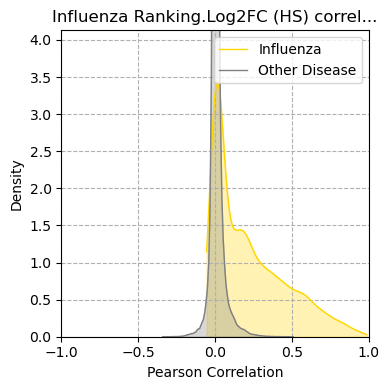

In [121]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    "COVID-19",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

for i, disease in enumerate(tqdm(single_disease_examples)):

    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
# Corrected function name and variable names for clarity
def get_top_k_library_strategies(disease, k=2, df_matrix=df_matrix):
    """Get Top K Library Strategies for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
        df_matrix (DataFrame): DataFrame containing the data
    Returns:
        list: list of k most common library strategies
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k_strategies = df_filtered["library_strategy"].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_per_strategy = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k_strategies:
        dsaids = df_filtered[df_filtered["library_strategy"] == strategy][
            "dsaid"
        ].tolist()
        dsaids_per_strategy.append(dsaids)

    return (top_k_strategies.tolist(), dsaids_per_strategy)


def get_top_k_tissues(disease, k=4, df_matrix=df_matrix):
    """Get Top K Tissues for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
    Returns
        tissues (list): list of k most common tissues
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k_strategies = df_filtered["tissue"].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_per_strategy = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k_strategies:
        dsaids = df_filtered[df_filtered["tissue"] == strategy]["dsaid"].tolist()
        dsaids_per_strategy.append(dsaids)

    return (top_k_strategies.tolist(), dsaids_per_strategy)


# Assuming 'df_data_info_processed_filtered' is your DataFrame and you want to find top 4 library strategies for "Covid-19"
top_k_library_strategies, dsaids_library_stratergies = get_top_k_library_strategies(
    "COVID-19", 2, df_matrix
)
print(top_k_library_strategies)

top_k_tissues, dsaids_tissues = get_top_k_tissues("COVID-19", 6, df_matrix)
print(top_k_tissues)

top_k_accessions, dsaids_accessions = get_top_k_accessions("COVID-19", 4, df_matrix)
print(top_k_accessions)

In [ ]:
def get_top_k(disease, field, k=4, df_matrix=df_matrix):
    """Get Top K Tissues for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
    Returns
        tissues (list): list of k most common tissues
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k = df_filtered[field].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_interest = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k:
        dsaids = df_filtered[df_filtered[field] == strategy]["dsaid"].tolist()
        dsaids_interest.append(dsaids)

    return (top_k.tolist(), dsaids_interest)

In [ ]:
df_matrix[df_matrix["disease"] == "COVID-19"]["library_strategy"].value_counts()

In [ ]:
top_k, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

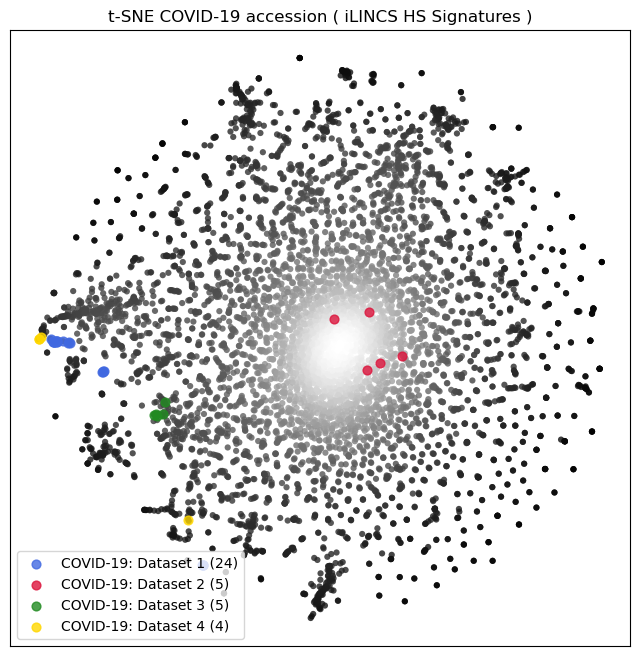

In [ ]:
# Tissue Bias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

disease = "COVID-19"
k = 4
field = "accession"
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=20,
    edgecolor="none",
    alpha=0.8,
)


# get specific tissues for disease
top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

for i, top_k in enumerate(top_ks):
    # dsaids for specific tissue
    dsaids_interest = top_k_dsaids[i]

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    if field == "accession":
        label_text = f"{disease}: Dataset {i+1} ({len(interest_idxs)})"

    else:
        label_text = f"{disease}: {top_k}"

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=label_text,
        s=40,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE {disease} {field} ( {metric_evaluated} {sparsity} Signatures )")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{disease}.{field}.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

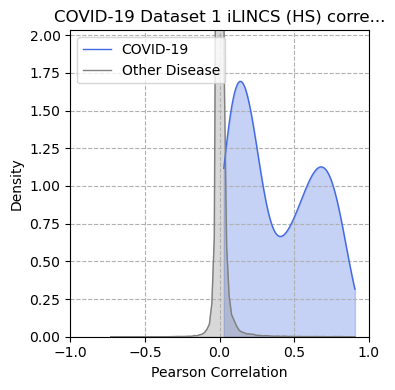

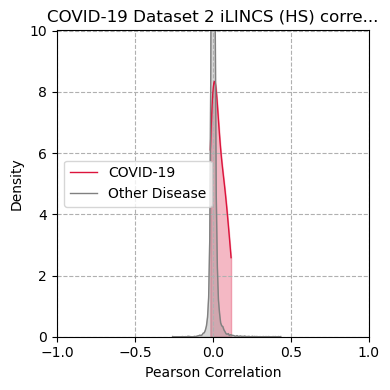

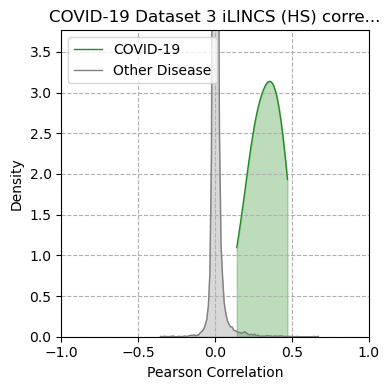

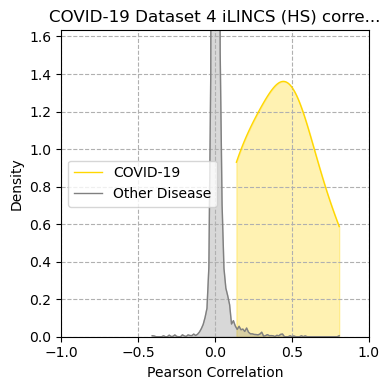

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

disease = "COVID-19"
k = 4
field = "accession"
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# get specific tissues for disease
top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

for i, top_k in enumerate(top_ks):
    # dsaids for specific tissue
    dsaids_interest = top_k_dsaids[i]

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    if field == "accession":
        title_example = (
            f"{disease} Dataset {i+1} {metric_evaluated} ({sparsity}) correlation"
        )
    else:
        title_example = (
            f"{disease} {top_k} {metric_evaluated} ({sparsity}) correlation "
        )

    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.{disease}.{field}.{i}.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    "Colon Cancer",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

for i, disease in enumerate(tqdm(single_disease_examples)):

    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

###  Check Lowest Correlation

In [ ]:
# imports

# variables


# functions
def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


# get lowest correlation diseases
list_of_min = [min(i) for i in correlation_values_interest_all]
idx_min_value = list_of_min.index(min(list_of_min))

dsaids_interest = dsaid_2_disease_filtered.get(most_common_diseases[idx_min_value])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
matrix_interest = data_matrix[interest_idxs]

logging.info(
    f"Lowest correlation found for disease: {most_common_diseases[idx_min_value]}"
)

logging.info(f"Nº signatures: {df_matrix[df_matrix['disease']==disease].shape[0]}")

for row_i in range(matrix_interest.shape[0]):

    for row_j in range(row_i + 1, matrix_interest.shape[0]):
        if row_i != row_j:

            _value = np.corrcoef(matrix_interest[row_i], matrix_interest[row_j])
            indxs = np.triu_indices_from(_value, k=1)
            _value = _value[indxs][0]
            if _value < -0.5:
                logging.info(
                    f"Low correlation between {dsaids_interest[row_i]} and {dsaids_interest[row_j]} {_value}"
                )
            # if row_j == 76:
            #     logging.info(f"{_value}")
            # if row_j == 55:
            #     logging.info(f"{_value}")

2024-02-26 12:06:40,549 - INFO - Lowest correlation found for disease: Asthma
2024-02-26 12:06:40,550 - INFO - Nº signatures: 12
2024-02-26 12:06:40,653 - INFO - Low correlation between DSA00628 and DSA01960 -0.5011290475737595
2024-02-26 12:06:41,020 - INFO - Low correlation between DSA03750 and DSA03751 -0.9174452809707316


In [ ]:
# Quality check
"""
Here we will from scratch get the correlation from the specified datasets
First approach will be to use entire data without any gene filtering

"""
# get specific DE data from dsaids of interest
de_values = list()
p_values = list()
genes_list = list()
for dsaid in ["DSA03750", "DSA03751"]:
    dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc = get_signatures(
        dsaid, remove_duplicates=True
    )
    de_values.append(log2fc)
    p_values.append(p_values)
    genes_list.append(genes)

logging.info(f"Nº of genes: {len(set(genes_list[0])&set(genes_list[1]))}")
logging.info(
    f"Nº of genes in common: {len(set(genes_list[0]).intersection(set(genes_list[1])))}"
)

# compute correlation

sorted_values_2 = sort_values(
    reference=genes_list[0],
    labels=genes_list[1],
    values=de_values[1],
    default_value=0,
)

np.corrcoef(de_values[0], sorted_values_2)[0, 1]

2024-02-26 12:47:34,302 - INFO - Nº of genes: 18795
2024-02-26 12:47:34,304 - INFO - Nº of genes in common: 18795


-0.9049100352822725

## Testing Area

In [ ]:
# All population (1)
import random

most_common_diseases[5]

all_indexes = np.arange(len(data_matrix))
dsaids_interest = dsaid_2_disease_filtered.get(most_common_diseases[5])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
logging.info(f"Interest subpopulation size: {len(interest_idxs)}")

# define population
population = list(set(all_indexes) - set(interest_idxs))
logging.info(f"Population size: {len(population)}")

# vectors subpopulation
vectors_subpopulation = data_matrix[interest_idxs]

# vectors population
vectors_population = data_matrix[population]

# compute correlation vs rest population
correlation_real = np.corrcoef(vectors_subpopulation, vectors_population)
correlation_real = correlation_real[: len(vectors_subpopulation)][
    :, len(vectors_subpopulation) :
]

logging.info(f"Correlation shape: {correlation_real.shape}")

values_correlation_real = correlation_real.flatten()

logging.info(f"Nº of computed values {len(values_correlation_real)}")

logging.info(f"Mean correlation: {np.mean(values_correlation_real)}")

# correlation subpopulation
correlation_subp = np.corrcoef(vectors_subpopulation)
indexes_under_diagonal = np.tril_indices(correlation_subp.shape[0], 1)
values_correlation_subp = correlation_subp[indexes_under_diagonal]

logging.info(f"Nº of computed values {len(values_correlation_subp)}")
logging.info(f"Mean correlation: {np.mean(values_correlation_subp)}")

2024-02-21 14:43:19,385 - INFO - Interest subpopulation size: 23
2024-02-21 14:43:19,387 - INFO - Population size: 6468
2024-02-21 14:43:22,866 - INFO - Correlation shape: (23, 6468)
2024-02-21 14:43:22,867 - INFO - Nº of computed values 148764
2024-02-21 14:43:22,867 - INFO - Mean correlation: 0.11100269217594927
2024-02-21 14:43:22,868 - INFO - Nº of computed values 298
2024-02-21 14:43:22,868 - INFO - Mean correlation: 0.31031870631622


In [ ]:
# All population approach (2)
import numpy as np
import logging

# Assuming the setup from your previous code:
most_common_diseases[5]
all_indexes = np.arange(len(data_matrix))
dsaids_interest = dsaid_2_disease_filtered.get(most_common_diseases[5])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
logging.info(f"Interest subpopulation size: {len(interest_idxs)}")

# Define population and subpopulation vectors
population = list(set(all_indexes) - set(interest_idxs))
logging.info(f"Population size: {len(population)}")
vectors_subpopulation = data_matrix[interest_idxs]
vectors_population = data_matrix[population]

# Prepare for individual correlation computation
individual_correlations = []

# Compute correlations individually
for idx_subpop in range(len(vectors_subpopulation)):
    for idx_pop in range(len(vectors_population)):
        correlation = np.corrcoef(
            vectors_subpopulation[idx_subpop], vectors_population[idx_pop]
        )[0, 1]
        individual_correlations.append(correlation)

# Now, individual_correlations contains all the pairwise correlation values
logging.info(
    f"Total number of individual correlations computed: {len(individual_correlations)}"
)
logging.info(f"Mean of individual correlations: {np.mean(individual_correlations)}")

2024-02-20 15:00:36,177 - INFO - Interest subpopulation size: 23
2024-02-20 15:00:36,178 - INFO - Population size: 6468
2024-02-20 15:00:44,719 - INFO - Total number of individual correlations computed: 148764
2024-02-20 15:00:44,723 - INFO - Mean of individual correlations: 0.11100269217594767


In [ ]:
# All population (3)

# compute pearson correlation for all
r_pearson = np.corrcoef(data_matrix)

# get indexes of interest

combination_1 = [(i, j) for i in interest_idxs for j in population]
row_index = [i[0] for i in combination_1]
col_index = [i[1] for i in combination_1]

np.mean(r_pearson[row_index, col_index])

0.11100269217594876

In [ ]:
# Sampling without replacement

# variables
proportion = 0.3

most_common_diseases[5]

all_indexes = np.arange(len(data_matrix))
dsaids_interest = dsaid_2_disease_filtered.get(most_common_diseases[5])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
logging.info(f"Interest subpopulation size: {len(interest_idxs)}")

# define population
population = list(set(all_indexes) - set(interest_idxs))
logging.info(f"Population size: {len(population)}")


# random indexes withtout replacement - appear once
population_sample = random.sample(list(population), int(proportion * len(population)))

# vectors subpopulation
vectors_subpopulation = data_matrix[interest_idxs]

# vectors population
vectors_population = data_matrix[population_sample]

# compute correlation
correlation_without_replacement = np.corrcoef(vectors_subpopulation, vectors_population)
correlation_without_replacement = correlation_without_replacement[
    : len(vectors_subpopulation)
][:, len(vectors_subpopulation) :]

logging.info(f"Correlation shape: {correlation_without_replacement.shape}")


values_correlation_without_replacement = correlation_without_replacement.flatten()

logging.info(f"Nº of computed values {len(values_correlation_without_replacement)}")
logging.info(f"Real : {np.mean(values_correlation_real)}")
logging.info(
    f"Sampling without replacement : {np.mean(values_correlation_without_replacement)}"
)

2024-02-20 15:12:15,622 - INFO - Interest subpopulation size: 23
2024-02-20 15:12:15,623 - INFO - Population size: 6468
2024-02-20 15:12:15,908 - INFO - Correlation shape: (23, 1940)
2024-02-20 15:12:15,908 - INFO - Nº of computed values 44620
2024-02-20 15:12:15,909 - INFO - Real : 0.11100269217594927
2024-02-20 15:12:15,909 - INFO - Sampling without replacement : 0.11277807159421611


In [ ]:
### Bootstrap Sampling
most_common_diseases[5]

all_indexes = np.arange(len(data_matrix))
dsaids_interest = dsaid_2_disease_filtered.get(most_common_diseases[5])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
logging.info(f"Interest subpopulation size: {len(interest_idxs)}")

# Define population excluding the interest indices
population = list(set(all_indexes) - set(interest_idxs))
logging.info(f"Population size: {len(population)}")

# Vectors for subpopulation of interest
vectors_subpopulation = data_matrix[interest_idxs]

bootstrap_samples = 100
correlations = []

for _ in range(bootstrap_samples):
    # Sample with replacement
    population_sample = np.random.choice(
        population, size=int(len(population) * 0.05), replace=True
    )

    # Vectors for sampled population
    vectors_population = data_matrix[population_sample]

    # Compute correlation for this bootstrap sample
    correlation = np.corrcoef(vectors_subpopulation, vectors_population)
    correlation = correlation[
        : len(vectors_subpopulation), len(vectors_subpopulation) :
    ]
    values_correlation = correlation.flatten()

    correlations.append(values_correlation)

# Aggregate correlation values across all bootstrap samples
all_values_correlation = np.concatenate(correlations)
mean_correlation = np.mean(all_values_correlation)

logging.info(
    f"Number of computed values across all bootstrap samples: {len(all_values_correlation)}"
)
logging.info(f"Real : {np.mean(values_correlation_real)}")

logging.info(f"Bootstrap samples: {mean_correlation}")

2024-02-20 15:34:51,586 - INFO - Interest subpopulation size: 23
2024-02-20 15:34:51,588 - INFO - Population size: 6468
2024-02-20 15:34:54,131 - INFO - Number of computed values across all bootstrap samples: 742900
2024-02-20 15:34:54,132 - INFO - Real : 0.11100269217594927
2024-02-20 15:34:54,132 - INFO - Bootstrap samples: 0.11094833820260643


In [ ]:
# bryan approach (3)
import torch


def pairwise_correlations(x, y, return_numpy=True):
    with torch.no_grad():
        if not torch.is_tensor(x):
            x = torch.tensor(x).cuda()
        if not torch.is_tensor(y):
            y = torch.tensor(y).cuda()
        r = torch_calculate_correlations(x, y)
        if return_numpy:
            r = r.cpu().numpy()
        return r


def torch_calculate_correlations(x, y):
    vx = x - torch.mean(x, dim=-1, keepdim=True)
    vy = y - torch.mean(y, dim=-1, keepdim=True)
    return torch.sum(vx * vy, dim=-1) / (
        torch.sqrt(torch.sum(vx**2, dim=-1)) * torch.sqrt(torch.sum(vy**2, dim=-1))
    )


m1 = np.random.rand(1, 500)
m2 = np.random.rand(1, 500)

cc = np.corrcoef(m1, m2)
indexes_under = np.tril_indices(cc.shape[0], 1)
print(cc[0, 1])
print(len(cc[indexes_under]))
print(np.mean(cc[indexes_under]))

cc = pairwise_correlations(m1, m2, return_numpy=True)
print(len(cc))
print(np.mean(cc))

0.0011962839679450256
4
0.5005981419839726


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import torch


def pairwise_correlations(x, y, return_numpy=True):
    with torch.no_grad():
        if not torch.is_tensor(x):
            x = torch.tensor(x)
        if not torch.is_tensor(y):
            y = torch.tensor(y)
        r = torch_calculate_correlations(x, y)
        if return_numpy:
            r = r.cpu().numpy()
        return r


def torch_calculate_correlations(x, y):
    vx = x - torch.mean(x, dim=-1, keepdim=True)
    vy = y - torch.mean(y, dim=-1, keepdim=True)
    return torch.sum(vx * vy, dim=-1) / (
        torch.sqrt(torch.sum(vx**2, dim=-1)) * torch.sqrt(torch.sum(vy**2, dim=-1))
    )


m1 = np.random.rand(1, 50)
m2 = np.random.rand(1, 50)

cc = np.corrcoef(m1, m2)
print(cc[0, 1])
cc = pairwise_correlations(m1, m2, return_numpy=True)
print(cc)

0.1237079580059839
[0.12370796]


In [ ]:
m1 = np.random.rand(3, 3)
m2 = np.random.rand(3, 3)

np.corrcoef(m1, m2)

array([[ 1.        , -0.95805303, -0.92543259, -0.96630107,  0.55277951,
        -0.86180222],
       [-0.95805303,  1.        ,  0.77802065,  0.85199499, -0.76841624,
         0.68028055],
       [-0.92543259,  0.77802065,  1.        ,  0.99178403, -0.19580211,
         0.98974102],
       [-0.96630107,  0.85199499,  0.99178403,  1.        , -0.31964082,
         0.9633325 ],
       [ 0.55277951, -0.76841624, -0.19580211, -0.31964082,  1.        ,
        -0.05368584],
       [-0.86180222,  0.68028055,  0.98974102,  0.9633325 , -0.05368584,
         1.        ]])

In [ ]:
import torch

# Ensure CUDA is available
if not torch.cuda.is_available():
    raise SystemError("CUDA is not available. Make sure you have a CUDA-enabled GPU.")

# Example tensors
A = torch.tensor([[1.0, 2, 3], [4, 5, 6]], device="cuda")
B = torch.tensor([[4.23, 6.23, 1.23], [17.5, 11.1, 12.4]], device="cuda")

# Move tensors to CUDA device
A = A.to("cuda")
B = B.to("cuda")

# Compute means
mean_A = A.mean(dim=1, keepdim=True)
mean_B = B.mean(dim=1, keepdim=True)

# Compute standard deviations
std_A = A.std(dim=1, keepdim=True)
std_B = B.std(dim=1, keepdim=True)

# Compute Pearson correlation coefficient
covariance = ((A - mean_A) * (B - mean_B)).mean(dim=1)
pearson_correlation = covariance / (std_A * std_B)

print("Pearson Correlation Coefficients:\n", pearson_correlation.cpu().numpy())

Pearson Correlation Coefficients:
 [[-0.3973597  -0.67551154]
 [-0.29561314 -0.5025424 ]]


In [ ]:
# concatenate A and B to compute correlation
C = torch.cat((A, B), dim=0)
print(C.shape)

torch.corrcoef(C)

torch.Size([4, 3])


tensor([[ 1.0000,  1.0000, -0.5960, -0.7538],
        [ 1.0000,  1.0000, -0.5960, -0.7538],
        [-0.5960, -0.5960,  1.0000, -0.0783],
        [-0.7538, -0.7538, -0.0783,  1.0000]], device='cuda:0')

#### Correlation Matrix No Loop

In [ ]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


from tqdm import tqdm

correlation_values_interest_all = list()
correlation_values_rest_all = list()

correlation_values_interest_mean = list()
correlation_values_rest_mean = list()

euclidean_values_interest_all = list()
euclidean_values_rest_all = list()

euclidean_values_interest_mean = list()
euclidean_values_rest_mean = list()

cosine_values_interest_all = list()
cosine_values_rest_all = list()

cosine_values_interest_mean = list()
cosine_values_rest_mean = list()

all_indexes = set(range(len(dsaids_matrix)))
for disease in tqdm(most_common_diseases):
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=100
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    # save correlation
    correlation_values_interest_all.append(correlation_values_interest)
    correlation_values_rest_all.append(correlation_values_rest)

    correlation_values_interest_mean.append(np.mean(correlation_values_interest))
    correlation_values_rest_mean.append(np.mean(correlation_values_rest))

    # compute euclidean distance
    euclidean_values_interest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    euclidean_values_rest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save euclidean distance
    euclidean_values_interest_all.append(euclidean_values_interest)
    euclidean_values_rest_all.append(euclidean_values_rest)

    euclidean_values_interest_mean.append(np.mean(euclidean_values_interest))
    euclidean_values_rest_mean.append(np.mean(euclidean_values_rest))

    # compute cosine distance
    cosine_values_interest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    cosine_values_rest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save cosine distance
    cosine_values_interest_all.append(cosine_values_interest)
    cosine_values_rest_all.append(cosine_values_rest)

    cosine_values_interest_mean.append(np.mean(cosine_values_interest))
    cosine_values_rest_mean.append(np.mean(cosine_values_rest))

    # check for NaN values
    if any(np.isnan(correlation_values_interest_mean)):
        print(f"NaN correlation found for disease: {disease}")
        print(f"Interest Indices: {interest_idxs}")
        raise ValueError("NaN correlation found")

NameError: name 'most_common_diseases' is not defined

#### Correlation Matrix Loop

In [ ]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform

k_percent = 0.2


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


from tqdm import tqdm

correlation_values_interest_all = list()
correlation_values_rest_all = list()

correlation_values_interest_mean = list()
correlation_values_rest_mean = list()

correlation_values_interest_top_k = list()
correlation_values_rest_top_k = list()

euclidean_values_interest_all = list()
euclidean_values_rest_all = list()

euclidean_values_interest_mean = list()
euclidean_values_rest_mean = list()

euclidean_values_interest_top_k = list()
euclidean_values_rest_top_k = list()

cosine_values_interest_all = list()
cosine_values_rest_all = list()

cosine_values_interest_mean = list()
cosine_values_rest_mean = list()

cosine_values_interest_top_k = list()
cosine_values_rest_top_k = list()

all_indexes = set(range(len(dsaids_matrix)))
for disease in tqdm(most_common_diseases):
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=100
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    # compute k correlations
    _sorted_correlation_values_interest = np.sort(correlation_values_interest)[::-1]

    _correlation_values_rest_top_k = list()
    for _ in range(200):
        random_rest_indexes = get_rest_indexes(
            interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=1
        )
        matrix_rest = data_matrix[random_rest_indexes]
        _correlation_computed = compute_pearson_correlation(
            matrix_interest, matrix_rest
        )
        _sorted_correlation_computed = np.sort(_correlation_computed)[::-1]
        _correlation_values_rest_top_k.extend(
            _sorted_correlation_computed[
                : int(k_percent * len(_sorted_correlation_computed))
            ]
        )

    # save correlation
    correlation_values_interest_all.append(correlation_values_interest)
    correlation_values_rest_all.append(correlation_values_rest)

    correlation_values_interest_mean.append(np.mean(correlation_values_interest))
    correlation_values_rest_mean.append(np.mean(correlation_values_rest))

    correlation_values_interest_top_k.append(
        _sorted_correlation_values_interest[
            : int(k_percent * len(_sorted_correlation_values_interest))
        ]
    )
    correlation_values_rest_top_k.append(_correlation_values_rest_top_k)
    # compute euclidean distance
    euclidean_values_interest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    euclidean_values_rest = compute_euclidean_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save euclidean distance
    euclidean_values_interest_all.append(euclidean_values_interest)
    euclidean_values_rest_all.append(euclidean_values_rest)

    euclidean_values_interest_mean.append(np.mean(euclidean_values_interest))
    euclidean_values_rest_mean.append(np.mean(euclidean_values_rest))

    # compute cosine distance
    cosine_values_interest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=None
    )
    cosine_values_rest = compute_cosine_distance(
        data_matrix_1=matrix_interest, data_matrix_2=matrix_rest
    )

    # save cosine distance
    cosine_values_interest_all.append(cosine_values_interest)
    cosine_values_rest_all.append(cosine_values_rest)

    cosine_values_interest_mean.append(np.mean(cosine_values_interest))
    cosine_values_rest_mean.append(np.mean(cosine_values_rest))

    # check for NaN values
    if any(np.isnan(correlation_values_interest_mean)):
        print(f"NaN correlation found for disease: {disease}")
        print(f"Interest Indices: {interest_idxs}")
        raise ValueError("NaN correlation found")

100%|██████████| 257/257 [03:03<00:00,  1.40it/s]


In [ ]:
perc = 0.2

interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
all_indexes = set(range(len(dsaids_matrix)))

all_values = list()
for _ in range(1000):

    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=1
    )

    matrix_rest = data_matrix[random_rest_indexes]

    values = np.corrcoef(matrix_interest, matrix_interest)[
        : matrix_interest.shape[0], matrix_interest.shape[0] :
    ]

    r = values[np.triu_indices_from(values, k=1)]
    # print(len(r))
    _sorted_r = np.sort(r)[::-1][: int(perc * len(r))]
    # print(len(_sorted_r))
    # print(len(r))
    # print(np.mean(_sorted_r))

    all_values.extend(_sorted_r)

print(np.mean(all_values))

values = np.corrcoef(matrix_interest)
r = values[np.triu_indices_from(values, k=1)]
_sorted_r = np.sort(r)[::-1][: int(perc * len(r))]
print(len(r))
print(np.mean(_sorted_r))
print(len(_sorted_r))

0.25375092794031057
190
0.25375092794031157
38


#### Correlation Bootstrap Resampling

In [ ]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform

k_percent = 0.2

bootstrap_samples = 100


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


# imports
from tqdm import tqdm


# variables


#  functions


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# # euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# # cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

In [ ]:
# imports
import random

# variables
n_bootstrap = 10

correlation_values_interest_all = list()
correlation_values_rest_all = list()

correlation_values_interest_top_k = list()
correlation_values_rest_top_k = list()


# functions
def check_old_method(dsais_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def get_top_k(array, k, percent=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = int(k * len(array))

    # Using numpy.argsort to get indices of the k top highest values
    indices = np.argsort(array)[-k:]

    # Sorting indices if you want them in the order of the corresponding values
    sorted_indices = indices[np.argsort(array[indices])][::-1]

    # Getting the top k values using the sorted indices
    top_k_values_from_indices = array[sorted_indices]
    return top_k_values_from_indices


# compute values
matrix_pearson_correlation = np.corrcoef(data_matrix)


# get values
quality_check = random.choice(list(range(len(most_common_diseases))))
logging.info(f"Quality check: {quality_check} {most_common_diseases[quality_check]}")

correlation_values_interest_all = list()
for disease in tqdm(most_common_diseases):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # interest indexes pairs
    """We have a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    interest_idxs_pairs = list()  # list of lists
    for i in range(len(interest_idxs)):
        _rows_list = list()  # list
        for j in range(len(interest_idxs)):
            if i != j:  # exclude itself from the comparison
                _rows_list.append([interest_idxs[i], interest_idxs[j]])
        interest_idxs_pairs.append(_rows_list)

    interest_idxs_pairs = np.array(interest_idxs_pairs)

    # get pearson correlation

    # iterate through all pairs for a given disease signature
    correlation_values_interest_top_k_per_disease = list()
    correlation_values_interest_per_disease = list()
    for row_interest in interest_idxs_pairs:

        # get correlation values for all elements of a row/signature
        correlation_values_interest = matrix_pearson_correlation[
            row_interest[:, 0], row_interest[:, 1]
        ]

        # get top k values
        top_k_values = get_top_k(correlation_values_interest, k=1)
        correlation_values_interest_top_k_per_disease.extend(top_k_values)
        correlation_values_interest_per_disease.extend(correlation_values_interest)

    # list of diseases with a list of similarities per disease
    correlation_values_interest_top_k.append(
        correlation_values_interest_top_k_per_disease
    )
    correlation_values_interest_all.append(correlation_values_interest_per_disease)

    # quality check
    if quality_check == 0:
        old_value = check_old_method(dsaids_interest, data_matrix)
        assert "%.7f" % old_value == "%.7f" % np.mean(
            correlation_values_interest_per_disease
        ), "Err something wrong computing correlation"

    # get rest indexes
    rest_indxs = list(set(all_indexes) - set(interest_idxs))

    # bootstrap method
    """Here we will create a list of list of lists. First list will be the nº 
    of resampling - the second will be a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs  """

    rest_idxs_pairs = list()  # list of list of lists
    for _ in range(n_bootstrap):
        # Sample with replacement
        rest_indxs_sample = np.random.choice(
            rest_indxs, size=int(len(interest_idxs)), replace=True
        )
        _rows_list_sublist = list()  # list of list
        for idx_interest in interest_idxs:
            _rows_list = list()  # list
            for idx_other in rest_indxs_sample:
                _rows_list.append([idx_interest, idx_other])
            _rows_list_sublist.append(_rows_list)
        rest_idxs_pairs.append(_rows_list_sublist)

    rest_idxs_pairs = np.array(rest_idxs_pairs)
    # get pearson correlation against random diseases

    # iterate through all the sample indexes
    correlation_values_rest_disease = list()
    correlation_values_top_k_disease = list()
    for sample_idxs in rest_idxs_pairs:
        correlation_values_sample = list()  # contains all values for a sample
        correlation_values_top_k_sample = list()  # contains top k values for a sample

        # iterate through list of all pairs for a given disease signature
        for row_sample_idxs in sample_idxs:

            # get for a given row all pre-computed correlation values
            correlation_values_rest = matrix_pearson_correlation[
                row_sample_idxs[:, 0], row_sample_idxs[:, 1]
            ]

            # get top k values
            top_k_values = get_top_k(correlation_values_rest, k=1)

            # append to list
            correlation_values_sample.extend(correlation_values_rest)
            correlation_values_top_k_sample.extend(top_k_values)

        # append to list of lists
        correlation_values_rest_disease.append(correlation_values_sample)
        correlation_values_top_k_disease.append(correlation_values_top_k_sample)

    # list of list of lists
    correlation_values_rest_all.append(correlation_values_rest_disease)
    correlation_values_rest_top_k.append(correlation_values_top_k_disease)


assert (
    len(most_common_diseases)
    == len(correlation_values_interest_all)
    == len(correlation_values_rest_all)
    == len(correlation_values_interest_top_k)
    == len(correlation_values_rest_top_k)
), "Err something wrong with the length of the lists"

2024-02-23 10:03:22,579 - INFO - Quality check: 188 Oral Squamous Cell Carcinoma
100%|██████████| 257/257 [00:50<00:00,  5.07it/s]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.]),
 array([-0.03544186, -0.02696848, -0.01849511, -0.01002174, -0.00154836,
         0.00692501,  0.01539839,  0.02387176,  0.03234513,  0.04081851,
         0.04929188,  0.05776526,  0.06623863,  0.074712  ,  0.08318538,
         0.09165875,  0.10013213,  0.1086055 ,  0.11707887,  0.12555225,
         0.13402562,  0.142499  ,  0.15097237,  0.15944574,  0.16791912,
         0.17639249,  0.18486587,  0.19333924,  0.20181261,  0.21028599,
         0.21875936,  0.22723274,  0.23570611,  0.24417948,  0.25265286,
         0.26112623,  0.26959961,  0.27

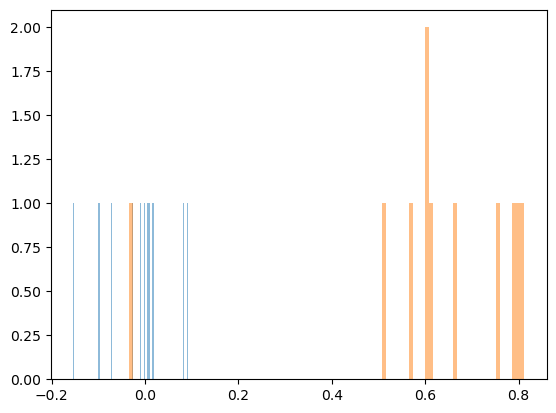

In [ ]:
plt.hist(correlation_values_rest, bins=100, alpha=0.5, label="Rest")
plt.hist(correlation_values_interest, bins=100, alpha=0.5, label="Interest")

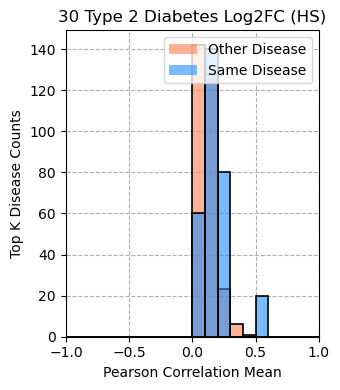

In [ ]:
# Plot Pearson Correlation - TOP K
# Correlation values mean with

for i, disease in enumerate(most_common_diseases):
    plt.close()
    # get interest indexes
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    value_1 = correlation_values_interest_top_k[i] * n_bootstrap
    value_2 = np.array(correlation_values_rest_top_k[i]).flatten()

    colors = {0: "#1E90FF", 1: "#FF7F50"}
    fixed_bins = [i for i in np.arange(-1, 1.01, 0.1)]

    # Create figure
    plt.figure(figsize=(3.5, 4))

    # Plot histogram for the fill with alpha=0.5
    n, bins, patches = plt.hist(
        value_2,
        bins=fixed_bins,
        alpha=0.6,
        edgecolor="none",
        color=colors[1],
        zorder=3,
        label="Other Disease",
    )

    # Plot histogram again for the edges with alpha=1
    plt.hist(
        value_2,
        bins=fixed_bins,
        linewidth=1.2,
        edgecolor="black",
        fill=False,
        zorder=3,
    )

    # Plot histogram for the fill with alpha=0.5
    n, bins, patches = plt.hist(
        value_1,
        bins=fixed_bins,
        alpha=0.6,
        edgecolor="none",
        color=colors[0],
        zorder=3,
        label="Same Disease",
    )

    # Plot histogram again for the edges with alpha=1
    plt.hist(
        value_1,
        bins=fixed_bins,
        linewidth=1.2,
        edgecolor="black",
        fill=False,
        zorder=3,
    )

    title_text = f"{len(dsaids_interest)} {disease} {metric_evaluated} ({sparsity})"
    title_text = title_text[:25] + "..." if len(title_text) > 30 else title_text
    # Finalizing plot
    plt.title(title_text)
    plt.legend()
    plt.xlabel("Pearson Correlation Mean")
    plt.xlim(-1, 1)
    # plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Top K Disease Counts")
    plt.grid(linestyle="--")
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"rm.top_1.pearson_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )
    if i == 12:
        break

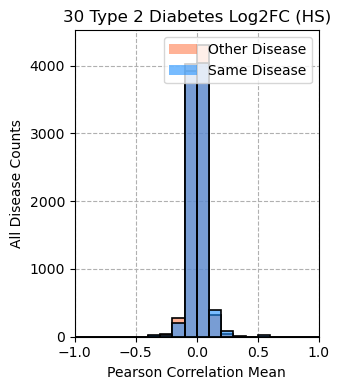

In [ ]:
# Plot Pearson Correlation - Mean
# Correlation values mean with

for i, disease in enumerate(most_common_diseases):
    plt.close()
    # get interest indexes
    dsaids_interest = dsaid_2_disease_filtered.get(disease)

    value_1 = correlation_values_interest_all[i] * n_bootstrap
    value_2 = np.array(correlation_values_rest_all[i]).flatten()

    colors = {0: "#1E90FF", 1: "#FF7F50"}
    fixed_bins = [i for i in np.arange(-1, 1.01, 0.1)]

    # Create figure
    plt.figure(figsize=(3.5, 4))

    # Plot histogram for the fill with alpha=0.5
    n, bins, patches = plt.hist(
        value_2,
        bins=fixed_bins,
        alpha=0.6,
        edgecolor="none",
        color=colors[1],
        zorder=3,
        label="Other Disease",
    )

    # Plot histogram again for the edges with alpha=1
    plt.hist(
        value_2,
        bins=fixed_bins,
        linewidth=1.2,
        edgecolor="black",
        fill=False,
        zorder=3,
    )

    # Plot histogram for the fill with alpha=0.5
    n, bins, patches = plt.hist(
        value_1,
        bins=fixed_bins,
        alpha=0.6,
        edgecolor="none",
        color=colors[0],
        zorder=3,
        label="Same Disease",
    )

    # Plot histogram again for the edges with alpha=1
    plt.hist(
        value_1,
        bins=fixed_bins,
        linewidth=1.2,
        edgecolor="black",
        fill=False,
        zorder=3,
    )

    title_text = f"{len(dsaids_interest)} {disease} {metric_evaluated} ({sparsity})"
    title_text = title_text[:25] + "..." if len(title_text) > 30 else title_text
    # Finalizing plot
    plt.title(title_text)
    plt.legend()
    plt.xlabel("Pearson Correlation Mean")
    plt.xlim(-1, 1)
    # plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("All Disease Counts")
    plt.grid(linestyle="--")
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"rm.all.pearson_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )
    if i == 12:
        break

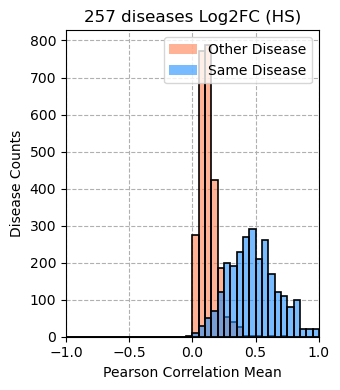

In [ ]:
# Plot Pearson Correlation
# Correlation values mean with


value_1 = [np.mean(x) for x in correlation_values_interest_top_k] * n_bootstrap
value_2 = [np.mean(x) for sample in correlation_values_rest_top_k for x in sample]


colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1.01, 0.05)]

# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

title_text = f"{len(most_common_diseases)} diseases {metric_evaluated} ({sparsity})"
title_text = title_text[:25] + "..." if len(title_text) > 30 else title_text
# Finalizing plot
plt.title(title_text)
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"rm.top_k.pearson_correlation.{sparsity}.{metric_evaluated}.mean.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

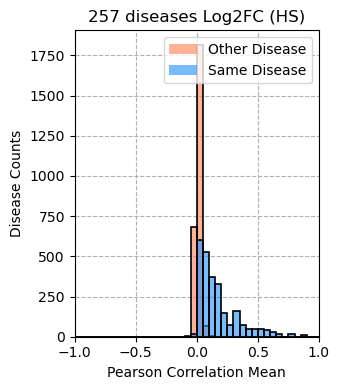

In [ ]:
# Plot Pearson Correlation
# Correlation values mean with


value_1 = [np.mean(x) for x in correlation_values_interest_all] * n_bootstrap
value_2 = [np.mean(x) for sample in correlation_values_rest_all for x in sample]


colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1.01, 0.05)]

# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

title_text = f"{len(most_common_diseases)} diseases {metric_evaluated} ({sparsity})"
title_text = title_text[:25] + "..." if len(title_text) > 30 else title_text
# Finalizing plot
plt.title(title_text)
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"rm.all.pearson_correlation.{sparsity}.{metric_evaluated}.mean.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

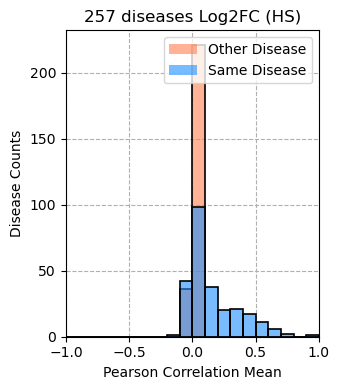

In [ ]:
# Plot Pearson Correlation
# Correlation values mean with


value_1 = correlation_values_interest_all
value_2 = correlation_values_rest_all


colors = {0: "#1E90FF", 1: "#FF7F50"}
fixed_bins = [i for i in np.arange(-1, 1.01, 0.1)]

# Create figure
plt.figure(figsize=(3.5, 4))

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_2,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[1],
    zorder=3,
    label="Other Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_2,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

# Plot histogram for the fill with alpha=0.5
n, bins, patches = plt.hist(
    value_1,
    bins=fixed_bins,
    alpha=0.6,
    edgecolor="none",
    color=colors[0],
    zorder=3,
    label="Same Disease",
)

# Plot histogram again for the edges with alpha=1
plt.hist(
    value_1,
    bins=fixed_bins,
    linewidth=1.2,
    edgecolor="black",
    fill=False,
    zorder=3,
)

title_text = f"{len(most_common_diseases)} diseases {metric_evaluated} ({sparsity})"
title_text = title_text[:25] + "..." if len(title_text) > 30 else title_text
# Finalizing plot
plt.title(title_text)
plt.legend()
plt.xlabel("Pearson Correlation Mean")
plt.xlim(-1, 1)
# plt.ylim(0, max(density_1(x_1)) * 1.2)
plt.ylabel("Disease Counts")
plt.grid(linestyle="--")
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"rm.pearson_correlation.{sparsity}.{metric_evaluated}.mean.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

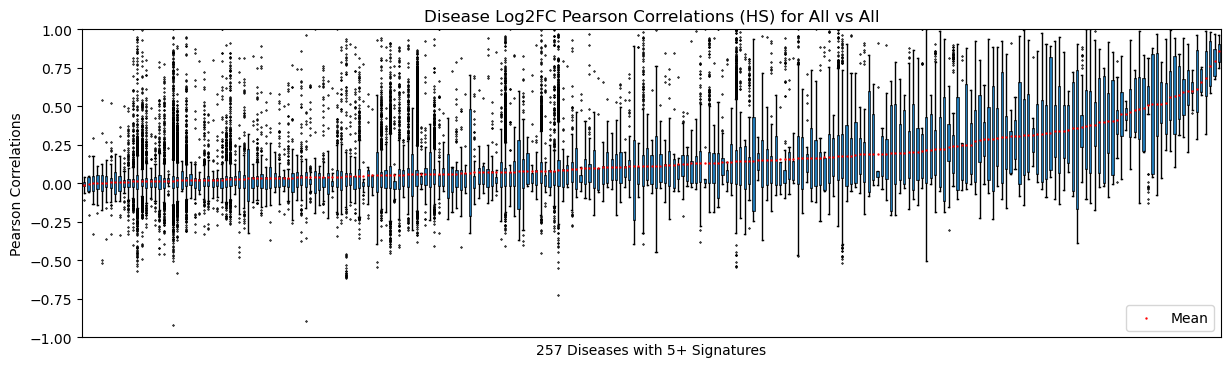

In [ ]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = [np.mean(c) for c in correlation_values_interest_all]
sorted_indices = np.argsort(means)
sorted_data = [data[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(14.7, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(
    f"Disease {metric_evaluated} Pearson Correlations ({sparsity}) for All vs All"
)
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"rm.boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

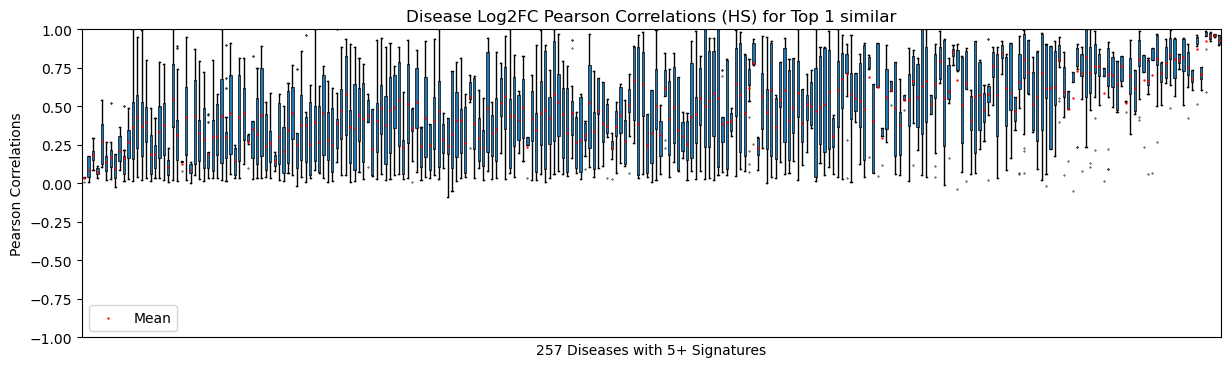

In [ ]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_top_k
# Calculate means and sort data based on these means
means = [np.mean(c) for c in correlation_values_interest_top_k]
# sorted_indices = np.argsort(means)
sorted_data = [data[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(14.7, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(
    f"Disease {metric_evaluated} Pearson Correlations ({sparsity}) for Top 1 similar"
)
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"rm.top_k.boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
def compute_ranking(values, n):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        # from 1 to n
        ranking[i] = 1 + counter

    # assifn values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        # from -n to -1
        ranking[i] = -n + counter

    return ranking


values = np.array([11, 2, 3, 4, 5, 6, 7, 8, 9, 10])

a = compute_ranking(values, n=3)
print(a)

[ 3. -3. -2. -1.  0.  0.  0.  0.  1.  2.]


In [ ]:
n = 3
values = np.array([11, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# initialize ranking values
ranking = np.zeros(len(values))

# get sorted indexes
sorted_indexes = np.argsort(values)

# assign values to n top values
for counter, i in enumerate(sorted_indexes[-n:]):
    # from 1 to n
    ranking[i] = 1 + counter

# assifn values to n bottom values
for counter, i in enumerate(sorted_indexes[:n]):
    # from -n to -1
    ranking[i] = -n + counter

print(ranking)

[ 3. -3. -2. -1.  0.  0.  0.  0.  1.  2.]


In [ ]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
a = np.array([1, 23, 4, 5, 6])

sorted_idxs = np.argsort(a)

for idx in sorted_idxs[:3]:
    print(a[idx])

1
4
5


In [ ]:
def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking

In [ ]:
values = np.array([-10, -0.1, -0.2, 1, 2, 3, 4, 5])
compute_ranking_log2fc(values, n=3, threshold=0.5)

array([-3.,  0.,  0.,  0.,  0.,  1.,  2.,  3.])

In [ ]:
values = np.array([0.0001, 0.0000000000001, 1, 2, 3, 4, 5])
compute_ranking_adj_pvalue(values, n=3, threshold=0.05)

array([2., 3., 0., 0., 0., 0., 0.])